In [48]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.patches as patches
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

In [3]:
X, y = mnist.data, mnist.target
# the data is stored as numpy arrays and has 70,000 images with 784 features (28x28 pixels)

'5'

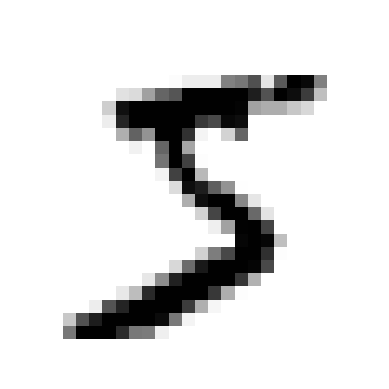

In [4]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
y[0]

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
# we first create a binary classifier for the number 5 so it can tell us if a digit is a 5 or not
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [7]:
# we start with a stochastic gradient descent classifier (SGD) which is capable of handling large datasets efficiently
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Measuring accuracy using cross validation

In [8]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [9]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train))) # no 5 detected

False


In [10]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')
# this only has 90% accuracy because only 10% of the images are 5s
# a better metric is the confusion matrix

array([0.90965, 0.90965, 0.90965])

In [11]:
# the following does roughly the same thing as cross_val_score() 
# it is for when you need more control over the cross-validation process
skfolds = StratifiedKFold(n_splits=3) # add shuffle=True to shuffle the data if it is not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [12]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
#perfroms K-fold cross-validation, returns the predictions made on each test fold it means that you get a clean prediction for each instance in the training set
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [13]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [14]:
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [15]:
# the F1 score is the harmonic mean of precision and recall 
# the classifier will only get a high F1 score if both recall and precision are high becuase it gives more weight to low values
f1_score(y_train_5, y_train_pred)
# the f1 score favors classifiers that have similar precision and recall 
# sometimes a human pipline is needed after the classifier to get the best results
# there is a tradeoff between precision and recall so when one goes up the other goes down

0.7325171197343846

In [16]:
# instead of calling the predict() method you can call the decision_function() method which returns a score for each instance
# if we want to change the threshold we can do so by changing the decision threshold
y_scores = sgd_clf.decision_function([some_digit])
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [17]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [18]:
# to decide which threshold to use we can use cross_val_predict() to get the scores of all instances in the training set but we get the scores instead of the predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

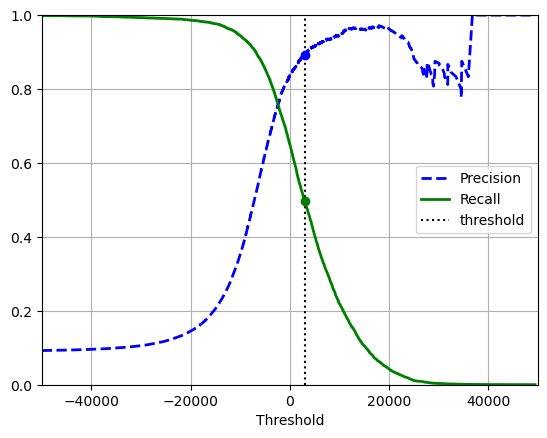

In [19]:
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label='threshold')
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

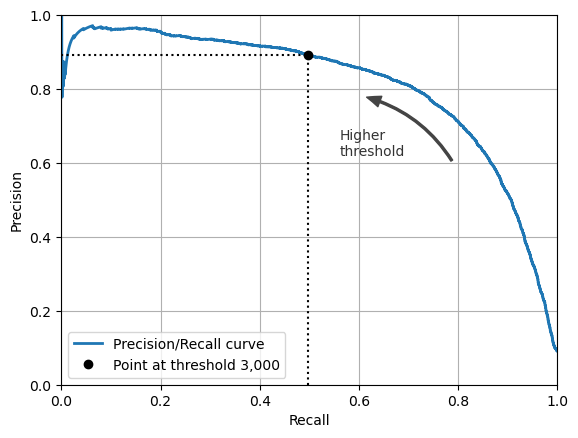

In [20]:
# another way to select a good precision/recall tradeoff is to plot precision directly against recall
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

In [21]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [22]:
# to make predictions with this new threshold we can do the following
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [23]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

THE ROC CURVE (Receiver Operating Characteristic)

In [24]:
# this is another common tool used with binary classifiers it is simalar to the precision/recall curve but instead of plotting precision versus recall it plots the true positive rate (another name for recall) against the false positive rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

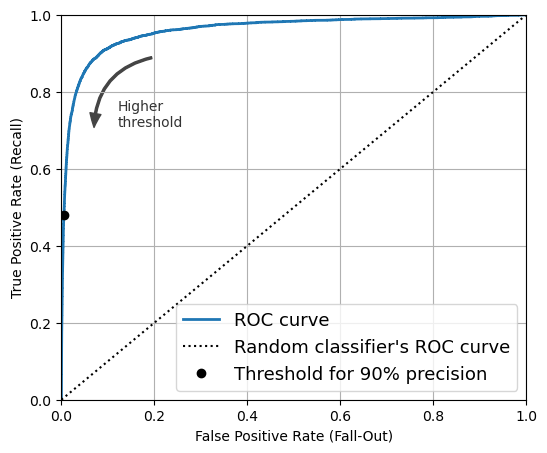

In [25]:
plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

In [26]:
# the higher the recall (TPR) the more false positives (FPR) the classifier produces
# one way to compare classifiers is to compare area under the curve a perfect classifier will have af roc auc =1 while a purely random classifier will have a roc auc = 0.5
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [27]:
# we now create a random forest classifier and compare its roc curve and roc auc score to the sgd classifier
forest_clf = RandomForestClassifier(random_state=42)
# we can call the cross_val_predict() function with the method='predict_proba' to get the scores instead of the predictions
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [28]:
# the second column represents the probability that the instance belongs to the positive class
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

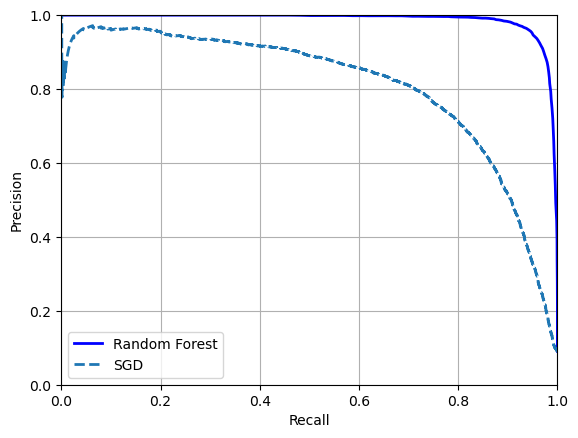

In [29]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# extra code – just beautifies and saves Figure 3–8
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

In [30]:
# this classifier looks much better since it has a higher precision at the same recall as the sgd classifier
# if we look at the f1 and roc auc scores we can see that the random forest classifier is also better
y_train_pred_forest = y_probas_forest[:, 1] > 0.5 # positive proba >= 0.5
print(f1_score(y_train_5, y_train_pred_forest))
print(roc_auc_score(y_train_5, y_scores_forest))

0.9242275142688446
0.9983436731328145


Multiclass classification (multinomial classification)

In [31]:
# this allows us to distinguish between more than two classes sgd and svc are both binary classifiers logistic regression and random forest are multiclass classifiers naturally
# you can however perform multiclass classification with binary classifiers with some strategies
# one way is to make a classifier for each single digit num then rank the scores and choose the higest as the prediction for what digit the image is this is called one versus all (OvA) or one versus the rest (OvR)
# another way is to train all the pairs then run the image through all the classifiers and see which one wins the most duels this is called one versus one (OvO)
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5

SVC(random_state=42)

In [32]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [33]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [34]:
class_id = some_digit_scores.argmax()
class_id

5

In [35]:
# when a classifer is trained it stores the list of target classes in its classes_ attribute ordered by value
# in this case the index of each class in the classes_ array conveniently matches the class itself but in general you wont be so lucky
# this is how you look up the class name
print("Classes:", svm_clf.classes_)
print(svm_clf.classes_[class_id])

Classes: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']
5


In [36]:
# if you want to force sklearn to use one versus one or one versus all you can use the OneVsOneClassifier or OneVsRestClassifier classes
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [37]:
print('prediction: ', ovr_clf.predict([some_digit]))
print(len(ovr_clf.estimators_))

prediction:  ['5']
10


In [38]:
# training an sgd classifier is as simple as this
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

Error Analysis

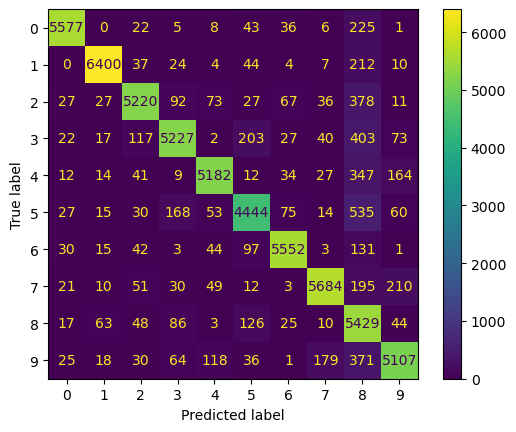

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

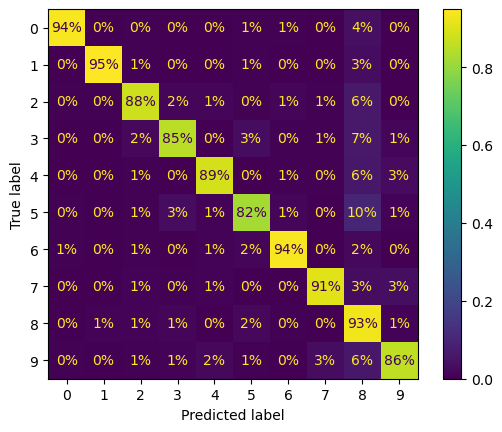

In [42]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%")
plt.show()
# this is normalized by the row sum so it shows the recall of each class rather than the number of correct predictions becuase there could be more of one class than another

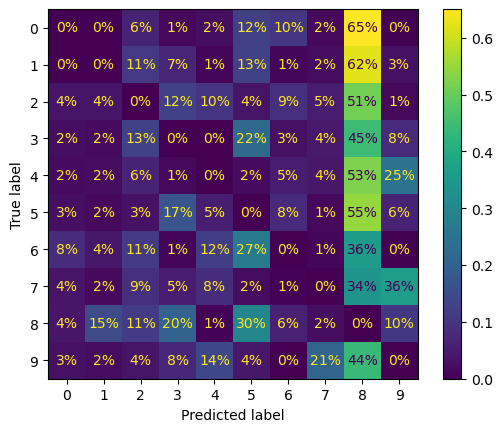

In [43]:
# this puts zero weight on the correct decisions so that we can better identify the errors
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format=".0%")

In [44]:
# analyziing individual errors can be a good way to gain insights on what your classifier is doing and why it is failing but it is more difficult and time consuming
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_81520/3373944487.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_81520/3373944487.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_81520/3373944487.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
/var/folders/8q/0wn9p2n54hb1x_gb6ckxsdxr0000gn/T/ipykernel_81520/3373944487.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementw

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

In [46]:
# a classifer that outputs multiple bianary tags is called a multilabel classifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [47]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [49]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])
chain_clf.predict([some_digit])

array([[0., 1.]])

MULTIOUTPUT CLASSIFICATION
a gneralization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).

In [50]:
# we will first add noise to the data
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

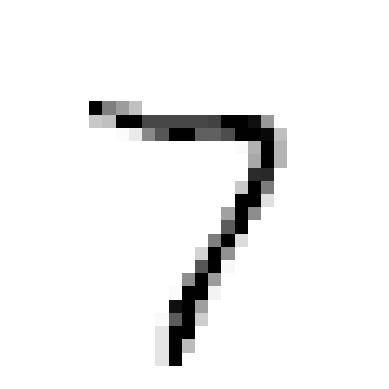

In [51]:
# we now can train the classifier and make it clean this image
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)